# Processing Pipeline for Flow Cytometry Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import fcsparser 
import glob
import size.viz
cor, pal = size.viz.matplotlib_style()

# Testing with glucose

In [2]:
# Examine the glucose samples. 
unstained_files = glob.glob('../../data/flow_cytometry/2022-12-15_wildtype/samples_Glu_unstain*')
stained_files = glob.glob('../../data/flow_cytometry/2022-12-15_wildtype/samples_Glu_DAPI*')
media_files = glob.glob('../../data/flow_cytometry/2022-12-15_wildtype/samples_Media_Glu_DAPI*')


In [3]:
unstained = pd.concat([fcsparser.parse(f)[1] for f in unstained_files])
stained = pd.concat([fcsparser.parse(f)[1] for f in stained_files])
media = pd.concat([fcsparser.parse(f)[1] for f in media_files])

In [4]:
len(media) / len(stained)


0.03462028286078155

Text(0, 0.5, 'DAPI')

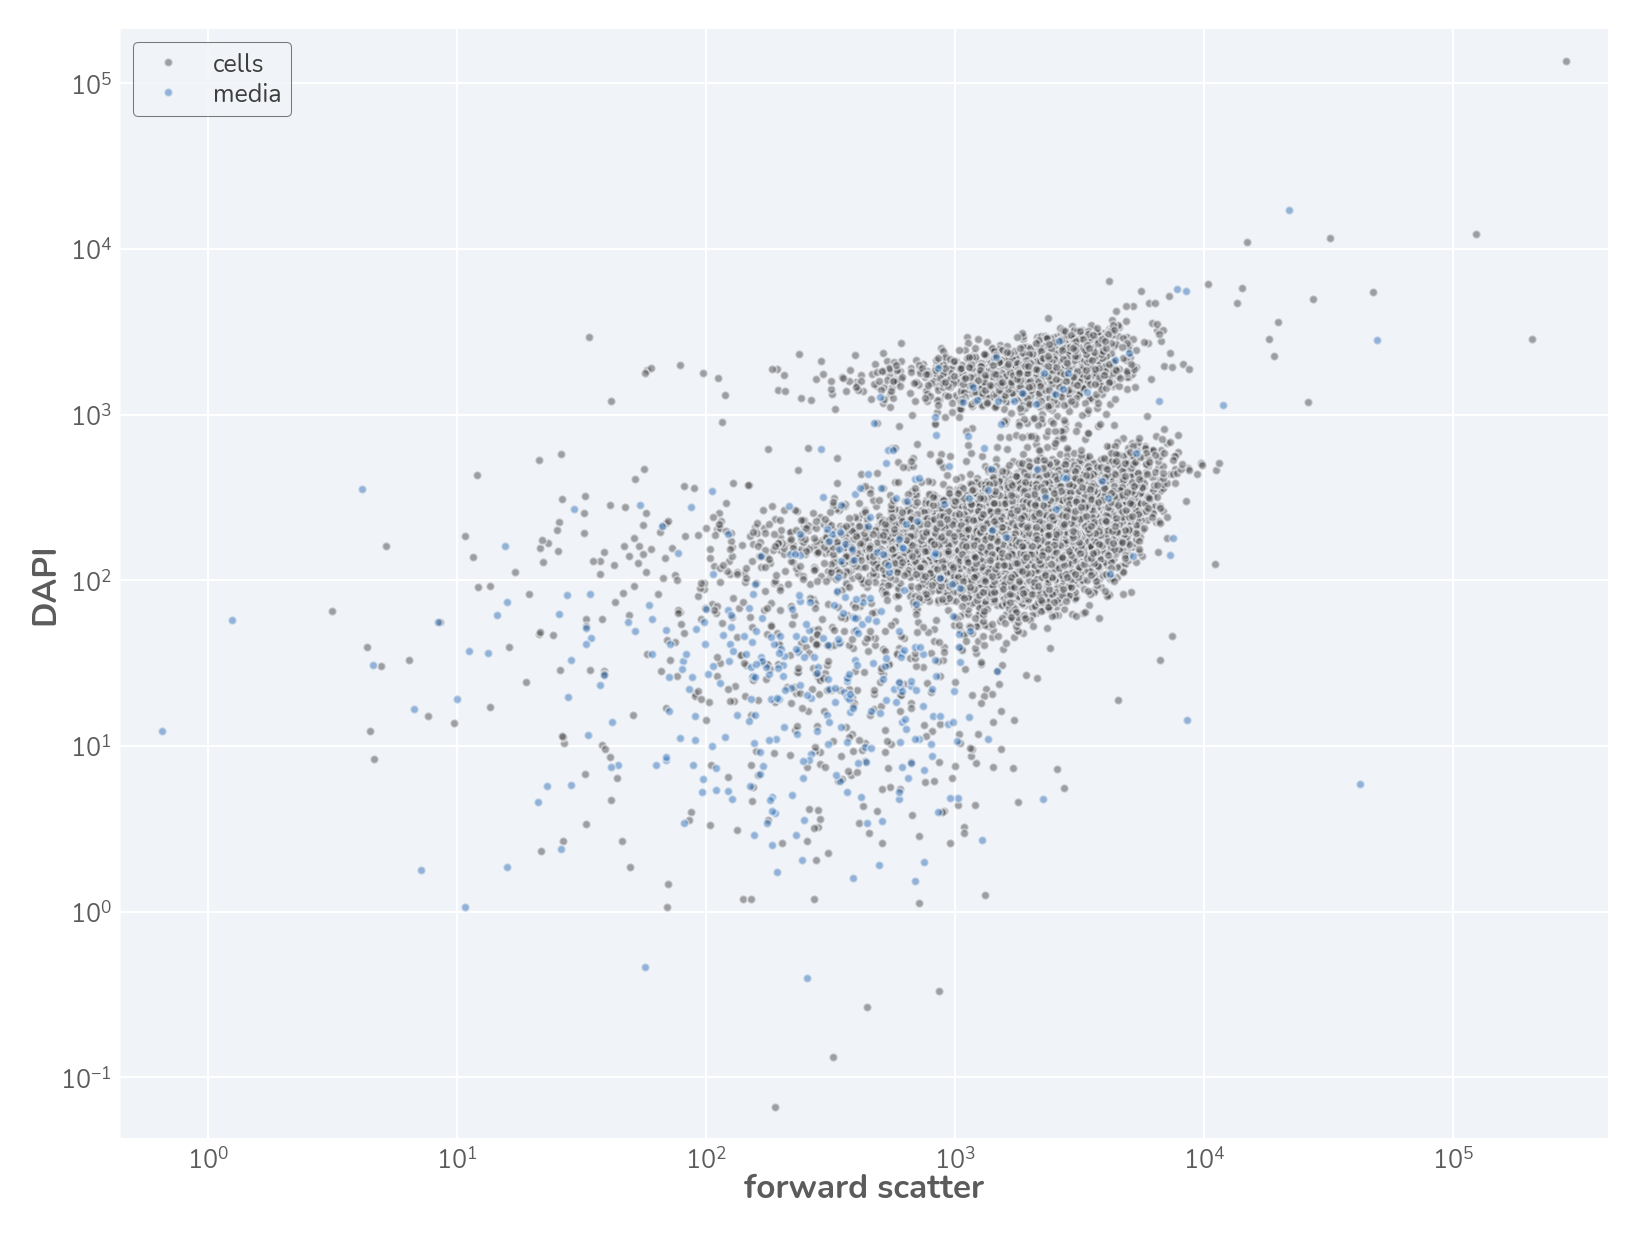

In [5]:
plt.loglog(stained['FSC-A'], stained['V450-A'], '.', ms=4, alpha=0.5, label='cells')
plt.loglog(media['FSC-A'], media['V450-A'], '.', ms=4, alpha=0.5,  label='media')
plt.legend()
plt.xlabel('forward scatter')
plt.ylabel('DAPI')

In [6]:
def apply_ecdf_gate(stained, 
              unstained, 
              colname='V450-A', 
              cdf_thresh=0.95, 
              positive=True):
    # Restruct to positive bounds if true 
    if positive:
        stained = stained[stained[colname] > 0].copy()
        unstained = unstained[unstained[colname] > 0].copy()

    # Compute the CDF on the unstained sample
    ind = np.where(np.arange(len(unstained))/len(unstained) >= cdf_thresh)[0][0]
    thresh = np.sort(unstained[colname])[ind]

    # Apply the gate
    stained['gated'] =  0
    stained.loc[stained[colname] >= thresh, 'gated'] = 1
    return stained

In [7]:
carbons = ['CAA', 'Glu', 'Gly', 'LB', 'Sorb2']
ods = [0.356, 0.295, 0.223, 0.244, 0.337]
cell_df = pd.DataFrame([])
integration_window = 1/6 # in min
dilution_factor = 91
flow_rate = 24 * 1E-3 # in mL per min
for i, c in enumerate(carbons):
    # Define files and load into dataframes
    stained_files = glob.glob(f'../../data/flow_cytometry/2022-12-15_wildtype/samples_{c}_DAPI*.fcs')
    # unstained_files = glob.glob(f'../../data/flow_cytometry/2022-12-15_wildtype/samples_{c}_unstain*.fcs')
    for j, f in enumerate(stained_files):
        stained = fcsparser.parse(f)[1]# for f in stained_files])
    # unstained = pd.concat([fcsparser.parse(f)[1] for f in unstained_files])

    # Apply the gating 
    # gated = apply_ecdf_gate(stained, unstained)
    # gated = gated[gated['gated']==1] 
    
        # compute the number of events detected
        n_events = len(stained)
        cells_per_measured_vol = n_events / (24 * (1/6))# ((n_events * 910 * 10) /(100 * 16)) * 1000
        cells_per_sample_dilution = cells_per_measured_vol* 910 / 100
        cells_per_uL_culture = cells_per_sample_dilution * 10 
        cells_per_mL = cells_per_uL_culture * 1000 * 0.780
        cells_per_biomass = cells_per_mL / ods[i]

        # Create the dataframe
        _df = pd.DataFrame([np.array([c, n_events, cells_per_mL, float(cells_per_biomass)])], 
                            columns=['carbon_source', 'n-events', 'cells_per_mL', 'cells_per_biomass'])
        _df['replicate'] = j+1
        cell_df = pd.concat([cell_df, _df], sort=False)

In [8]:
cell_df

,carbon_source,n-events,cells_per_mL,cells_per_biomass,replicate
0,CAA,11389,202097805.0,567690463.4831461,1
0,CAA,12641,224314545.0,630097036.5168539,2
0,CAA,12849,228005505.0,640464901.6853933,3
0,CAA,12501,221830245.0,623118665.7303371,4
0,Glu,7386,131064570.0,444286677.9661017,1
0,Glu,6709,119051205.0,403563406.77966106,2
0,Glu,7806,138517470.0,469550745.7627119,3
0,Glu,7937,140842065.0,477430728.81355935,4
0,Gly,13007,230809215.0,1035018901.3452915,1
0,Gly,12606,223693470.0,1003109730.941704,2


Text(0, 0.5, 'cells / OD [$\\times$10$^9$]')

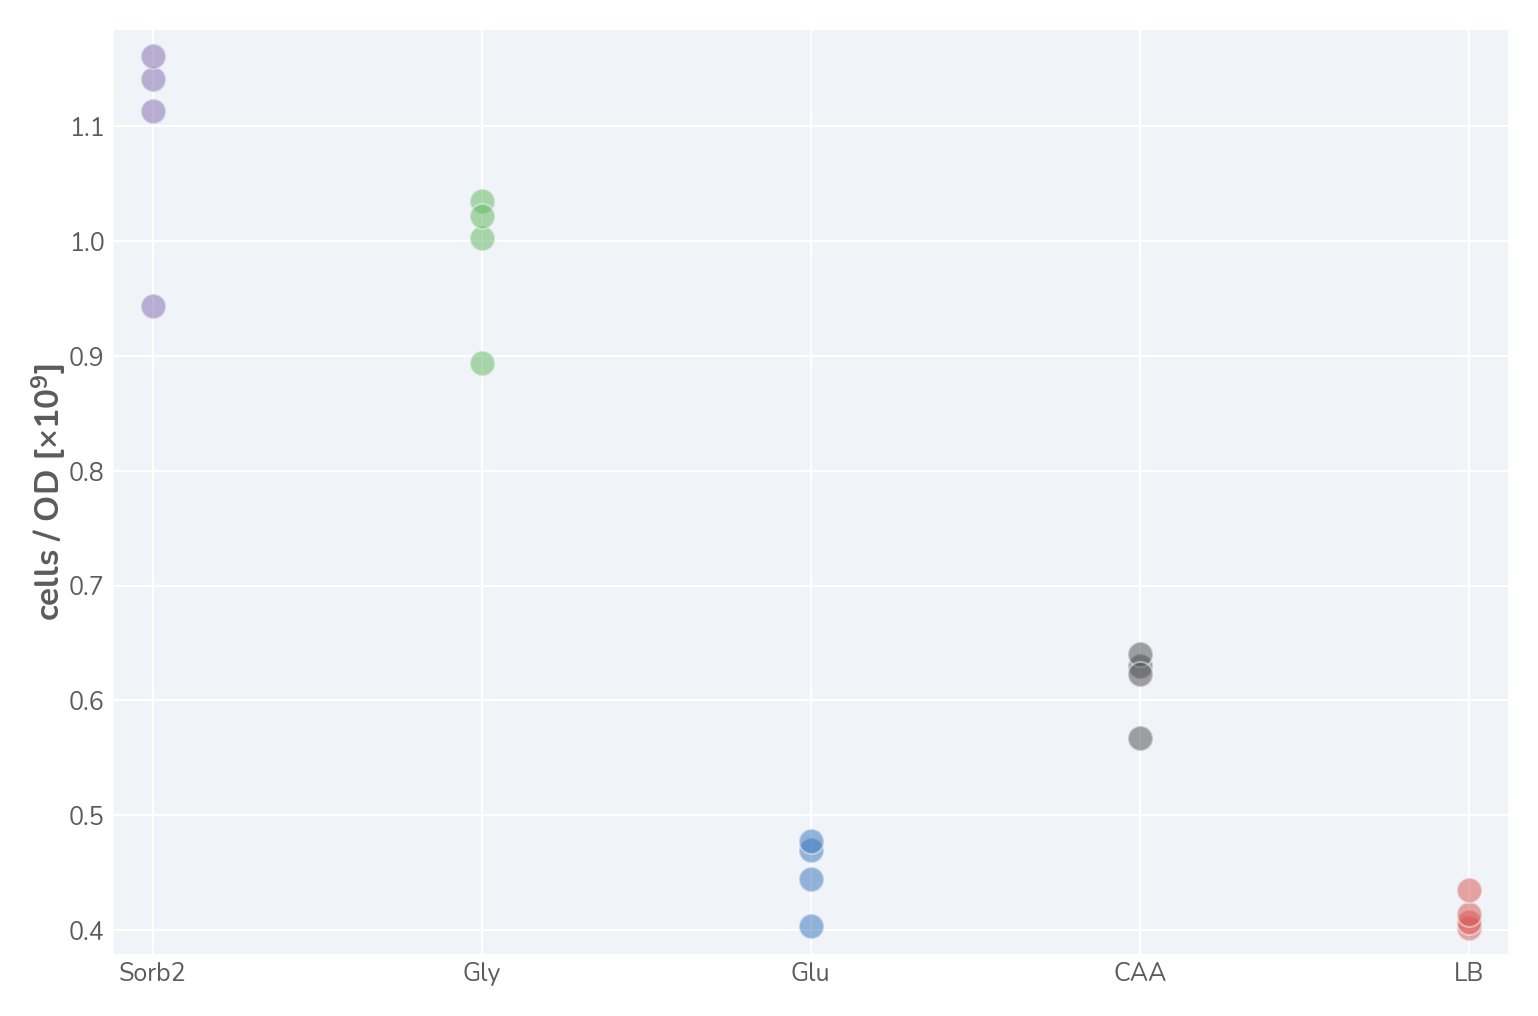

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
i = 0
labs = ['Sorb2', 'Gly', 'Glu', 'CAA', 'LB']
idx = {l:i for i, l in enumerate(labs)}
for g, d in cell_df.groupby(['carbon_source']):
    ax.plot(np.ones(len(d)) * idx[g], d['cells_per_biomass'].values.astype(float) / 1E9, 'o', alpha=0.5)

    i += 1
ax.set_xticks(np.arange(i))
ax.set_xticklabels(labs)
ax.set_ylabel(r'cells / OD [$\times$10$^9$]')

In [65]:
d['cells_per_biomass'].values[0]

'797285585.2601156'

In [40]:
gated = apply_ecdf_gate(stained, unstained)

In [52]:
91 * len(gated) / (24 * (10/60) * 4) / 0.346

482960.80202312145

In [42]:
len(gated)


29381

In [43]:
len(gated[gated['gated']==1])

28806

In [28]:
# Restrict
# Compute the ecdf of the fsc and dapi signal for the media 
_y = np.arange(len(media)) / len(media)
ind = np.where(_y >= 0.95)[0][0]
fsc_thresh = np.sort(media['FSC-A'])[ind]
dapi_thresh = np.sort(media['V450-A'])[ind]
unstained_threshed = stained[(stained['FSC-A'] >= fsc_thresh) & (stained['V450-A'] >= dapi_thresh)]

In [32]:
fsc_thresh

1079.6807

In [31]:
unstained_threshed

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,V450-A,Time


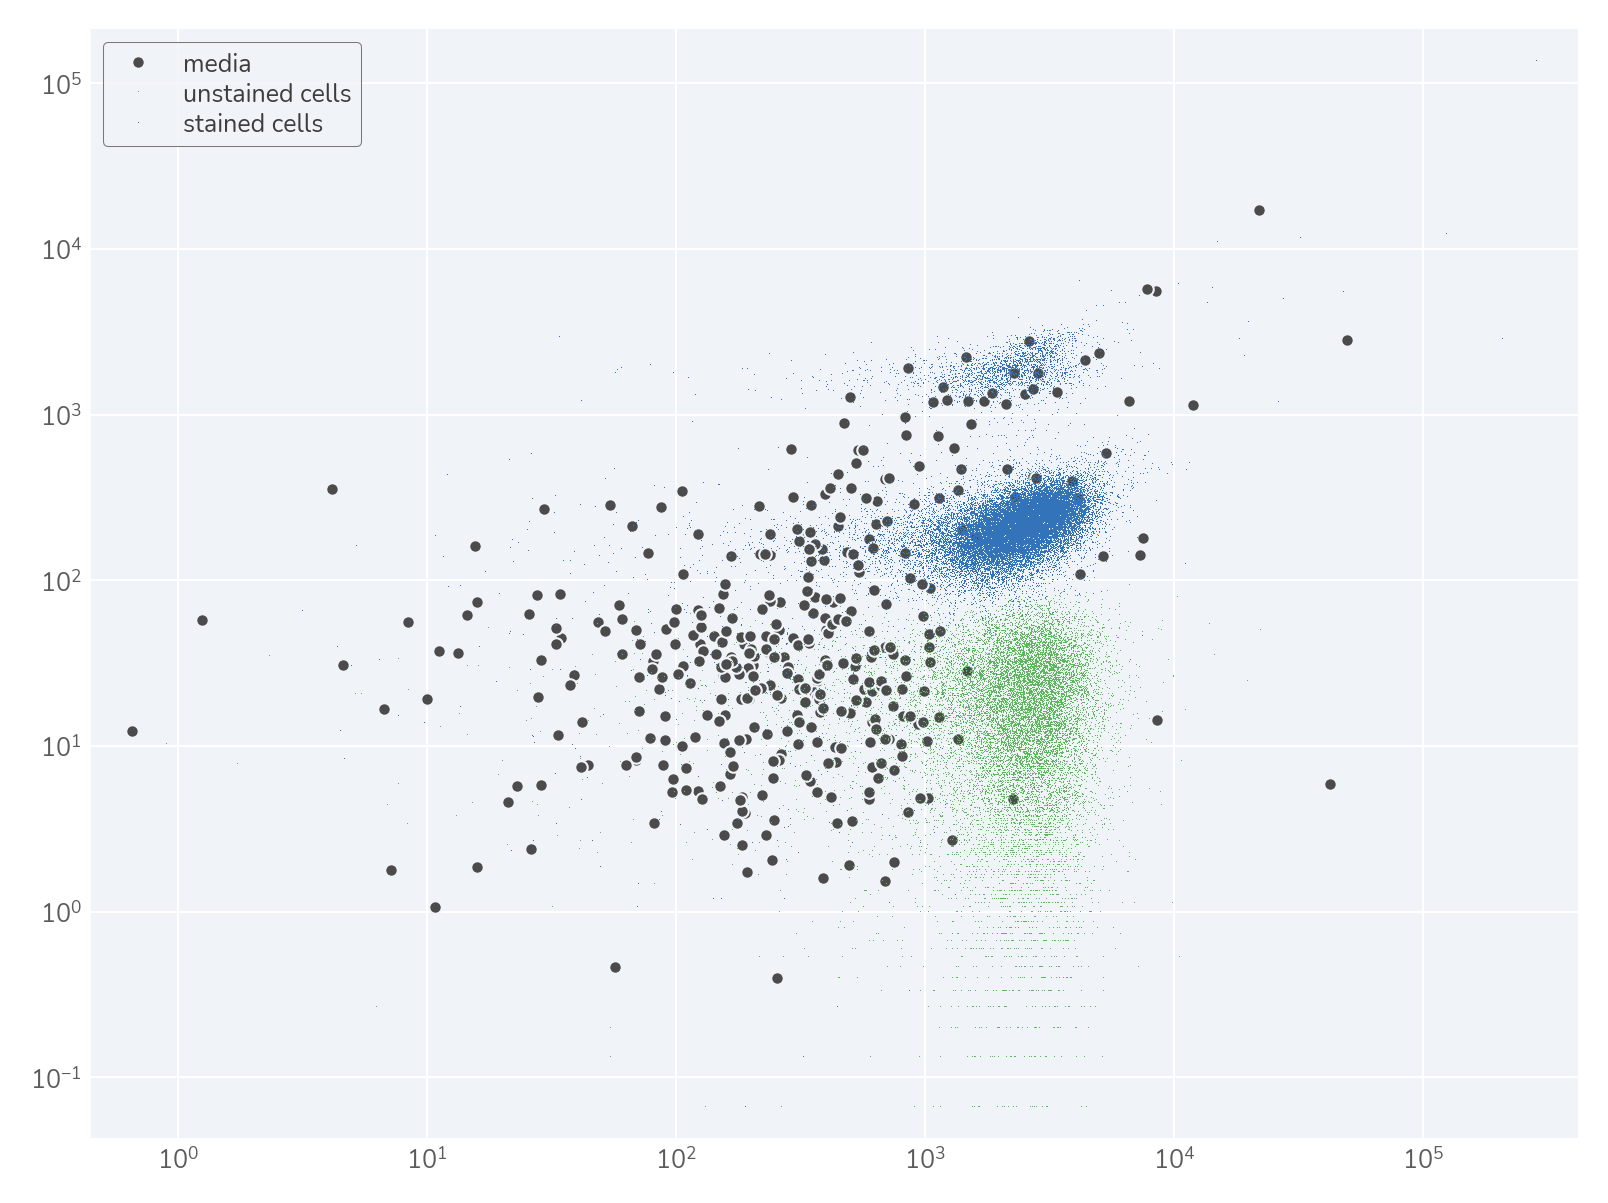

In [36]:
plt.loglog(media['FSC-A'], media['V450-A'], '.', color=cor['primary_black'], label='media')
plt.loglog(unstained['FSC-A'], unstained['V450-A'], ',', color=cor['primary_green'], label='unstained cells')
plt.loglog(stained['FSC-A'], stained['V450-A'], ',', color=cor['primary_blue'], label='stained cells')
plt.legend()